# Enhanced Documentation Repository EDA - Comprehensive Analysis

This notebook provides a comprehensive exploratory data analysis of the BlueXP documentation repository, including:
- File structure and organization patterns
- Content analysis and quality metrics
- Documentation completeness assessment
- Naming conventions and consistency
- Interactive visualizations and insights


## Notebook Imports

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

## Data Collection

In [2]:
def scan_documentation_repo(repo_path, file_extensions=['.adoc', '.md', '.yml', '.yaml', '.json']):
    files_data = []
    
    for root, dirs, files in os.walk(repo_path):
    
        for file in files:
            if any(file.endswith(ext) for ext in file_extensions):
                file_path = Path(root) / file
                relative_path = file_path.relative_to(repo_path)
                
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                    
                    files_data.append({
                        'filename': file,
                        'path': str(relative_path),
                        'directory': str(relative_path.parent),
                        'extension': file_path.suffix,
                        'size_bytes': file_path.stat().st_size,
                        'content': content,
                        'depth': len(relative_path.parts) - 1
                    })
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
    
    return pd.DataFrame(files_data)

df = scan_documentation_repo('../data/bluexp-dataset')
print(f"Loaded {len(df)} documentation files")
df.head()

Loaded 194 documentation files


,filename,path,directory,extension,size_bytes,content,depth
0,_index.yml,_index.yml,.,.yml,3384,uuid: 14df382f-48fa-5fd7-a8f0-40ee98580bd4\nin...,0
1,project.yml,project.yml,.,.yml,710,uuid: d418768b-3497-547c-af79-bf44964603cc\nse...,0
2,README.md,README.md,.,.md,550,# BlueXP Automation\n\nWelcome to the open-sou...,0
3,legal-notices.adoc,legal-notices.adoc,.,.adoc,497,// uuid: 80e4f7bb-32c7-594b-8c6b-034c42b4a3b6\...,0
4,sidebar.yml,api-cm/sidebar.yml,api-cm,.yml,12819,uuid: 55909472-99fa-5a23-bdc9-74ab1f4f12be\nse...,1


## Exploratory Data Analysis (EDA)

In [3]:
def analyze_content_metrics(df):    

    df['line_count'] = df['content'].apply(lambda x: len(x.split('\n')))
    df['word_count'] = df['content'].apply(lambda x: len(x.split()))
    df['char_count'] = df['content'].apply(len)
    df['avg_line_length'] = df['char_count'] / df['line_count']
    df['avg_word_length'] = df['char_count'] / df['word_count']
    
    def count_headers(content, extension):
        if extension in ['.md']:
            # Markdown headers
            h1 = len(re.findall(r'^# ', content, re.MULTILINE))
            h2 = len(re.findall(r'^## ', content, re.MULTILINE))
            h3 = len(re.findall(r'^### ', content, re.MULTILINE))
        elif extension in ['.adoc']:
            # AsciiDoc headers
            h1 = len(re.findall(r'^= ', content, re.MULTILINE))
            h2 = len(re.findall(r'^== ', content, re.MULTILINE))
            h3 = len(re.findall(r'^=== ', content, re.MULTILINE))
        else:
            # JSON/YAML files don't have headers
            h1, h2, h3 = 0, 0, 0
        return h1, h2, h3
    
    header_counts = df.apply(lambda row: count_headers(row['content'], row['extension']), axis=1)
    df['h1_count'] = [counts[0] for counts in header_counts]
    df['h2_count'] = [counts[1] for counts in header_counts]
    df['h3_count'] = [counts[2] for counts in header_counts]
    df['total_headers'] = df['h1_count'] + df['h2_count'] + df['h3_count']
    
    def count_links(content, extension):
        if extension in ['.md']:
            # Markdown links
            internal = len(re.findall(r'\[.*?\]\((?!http)', content))
            external = len(re.findall(r'\[.*?\]\(http', content))
        elif extension in ['.adoc']:
            # AsciiDoc links
            internal = len(re.findall(r'<<[^>]+>>', content)) 
            external = len(re.findall(r'link:https?://[^\s\]]+', content))
        else:
            # JSON/YAML files don't typically have links
            internal, external = 0, 0
        return internal, external
    
    link_counts = df.apply(lambda row: count_links(row['content'], row['extension']), axis=1)
    df['internal_links'] = [counts[0] for counts in link_counts]
    df['external_links'] = [counts[1] for counts in link_counts]
    df['total_links'] = df['internal_links'] + df['external_links']
    df['link_density'] = (df['total_links'] / df['word_count'] * 100).fillna(0)
    
    def count_code_blocks(content, extension):
        if extension in ['.md']:
            # Markdown code blocks
            code_blocks = len(re.findall(r'```', content)) // 2
        elif extension in ['.adoc']:
            # AsciiDoc code blocks
            code_blocks = len(re.findall(r'^----$', content, re.MULTILINE)) // 2
        else:
            # JSON/YAML files are essentially code themselves
            code_blocks = 1 if len(content.strip()) > 0 else 0
        return code_blocks
    
    df['code_blocks'] = df.apply(lambda row: count_code_blocks(row['content'], row['extension']), axis=1)
    df['inline_code'] = df['content'].apply(lambda x: len(re.findall(r'`[^`]+`', x)))
    df['api_endpoints'] = df['content'].apply(lambda x: len(re.findall(r'/api/|/v\d+/', x)))
    
    # Quality indicators - Different logic for different file types
    def check_quality_indicators(content, extension):
        if extension in ['.md', '.adoc']:
            # Documentation files
            has_toc = 'table of contents' in content.lower() or 'toc' in content.lower()
            has_examples = 'example' in content.lower()
        else:
            # JSON/YAML files - check for structure indicators
            has_toc = False  # No TOC in config files
            has_examples = 'example' in content.lower() or 'sample' in content.lower()
        return has_toc, has_examples
    
    quality_checks = df.apply(lambda row: check_quality_indicators(row['content'], row['extension']), axis=1)
    df['has_toc'] = [check[0] for check in quality_checks]
    df['has_examples'] = [check[1] for check in quality_checks]
    
    # Content categories
    df['is_config'] = df['extension'].isin(['.yml', '.yaml', '.json'])
    df['is_documentation'] = df['extension'].isin(['.md', '.adoc'])
    
    return df

df = analyze_content_metrics(df)
df[['filename', 'extension', 'word_count', 'total_headers', 'total_links', 'code_blocks']].head()

,filename,extension,word_count,total_headers,total_links,code_blocks
0,_index.yml,.yml,377,0,0,1
1,project.yml,.yml,83,0,0,1
2,README.md,.md,75,1,1,0
3,legal-notices.adoc,.adoc,46,1,0,0
4,sidebar.yml,.yml,1158,0,0,1


In [4]:
def generate_comprehensive_insights(df):    
    insights = {}
    doc_files = df[df['is_documentation']]
    config_files = df[df['is_config']]
    
    # Basic statistics
    insights['total_files'] = len(df)
    insights['documentation_files'] = len(doc_files)
    insights['config_files'] = len(config_files)
    insights['avg_file_size'] = df['size_bytes'].mean()
    insights['total_content_size'] = df['size_bytes'].sum()
    
    # Content quality metrics
    insights['avg_word_count'] = doc_files['word_count'].mean()
    insights['total_words'] = doc_files['word_count'].sum()
    insights['files_with_structure'] = (doc_files['total_headers'] > 0).sum()
    insights['files_with_examples'] = doc_files['has_examples'].sum()
    insights['files_with_code'] = (doc_files['code_blocks'] > 0).sum()
    
    # Directory analysis
    insights['unique_directories'] = df['directory'].nunique()
    insights['max_depth'] = df['depth'].max()
    insights['avg_files_per_dir'] = len(df) / df['directory'].nunique()
    
    # Quality indicators
    insights['documentation_completeness'] = {
        'with_headers': (doc_files['total_headers'] > 0).sum() / len(doc_files) * 100,
        'with_links': (doc_files['total_links'] > 0).sum() / len(doc_files) * 100,
        'with_examples': doc_files['has_examples'].sum() / len(doc_files) * 100,
        'with_code_blocks': (doc_files['code_blocks'] > 0).sum() / len(doc_files) * 100,
        'with_toc': doc_files['has_toc'].sum() / len(doc_files) * 100
    }
    
    # Content distribution
    insights['file_type_distribution'] = df['extension'].value_counts().to_dict()
    insights['top_directories'] = df['directory'].value_counts().head(5).to_dict()
    
    return insights

def print_insights_report(insights):
        
    print(f"\n Repo Overview")
    print(f"   • Total Files: {insights['total_files']:,}")
    print(f"   • Documentation Files: {insights['documentation_files']:,} ({insights['documentation_files']/insights['total_files']*100:.1f}%)")
    print(f"   • Configuration Files: {insights['config_files']:,} ({insights['config_files']/insights['total_files']*100:.1f}%)")
    print(f"   • Total Content Size: {insights['total_content_size']/1024:.1f} KB")
    print(f"   • Average File Size: {insights['avg_file_size']:.0f} bytes")
    
    print(f"\n Content")
    print(f"   • Total Words: {insights['total_words']:,}")
    print(f"   • Average Words per Document: {insights['avg_word_count']:.0f}")
    
    print(f"\n STRUCTURE")
    print(f"   • Unique Directories: {insights['unique_directories']}")
    print(f"   • Maximum Directory Depth: {insights['max_depth']}")
    print(f"   • Average Files per Directory: {insights['avg_files_per_dir']:.1f}")
    
    print(f"\n DOCUMENTATION QUALITY METRICS")
    completeness = insights['documentation_completeness']
    print(f"   • Files with Headers: {completeness['with_headers']:.1f}%")
    print(f"   • Files with Links: {completeness['with_links']:.1f}%")
    print(f"   • Files with Examples: {completeness['with_examples']:.1f}%")
    print(f"   • Files with Code Blocks: {completeness['with_code_blocks']:.1f}%")
    print(f"   • Files with Table of Contents: {completeness['with_toc']:.1f}%")
    
    print(f"\n📁 FILE TYPE DISTRIBUTION")
    for ext, count in insights['file_type_distribution'].items():
        percentage = count / insights['total_files'] * 100
        print(f"   • {ext}: {count} files ({percentage:.1f}%)")
    
    print(f"\n🔝 TOP DIRECTORIES")
    for directory, count in insights['top_directories'].items():
        print(f"   • {directory}: {count} files")
    
    print("\n" + "="*80)

insights = generate_comprehensive_insights(df)
print_insights_report(insights)


 Repo Overview
   • Total Files: 194
   • Documentation Files: 159 (82.0%)
   • Configuration Files: 35 (18.0%)
   • Total Content Size: 3345.9 KB
   • Average File Size: 17661 bytes

 Content
   • Total Words: 129,725
   • Average Words per Document: 816

 STRUCTURE
   • Unique Directories: 16
   • Maximum Directory Depth: 1
   • Average Files per Directory: 12.1

 DOCUMENTATION QUALITY METRICS
   • Files with Headers: 100.0%
   • Files with Links: 61.0%
   • Files with Examples: 89.3%
   • Files with Code Blocks: 39.0%
   • Files with Table of Contents: 20.1%

📁 FILE TYPE DISTRIBUTION
   • .adoc: 158 files (81.4%)
   • .yml: 18 files (9.3%)
   • .json: 16 files (8.2%)
   • .md: 1 files (0.5%)
   • .yaml: 1 files (0.5%)

🔝 TOP DIRECTORIES
   • cm: 139 files
   • platform: 17 files
   • .: 4 files
   • credential: 3 files
   • cbs: 3 files



### File Types
The repo consists of a total of five (5) file types:
- AsciiDoc (adoc)
- JSON
- YML
- YMAL
- MD (README)

As can be seen in the below visualization, the preponderance of these files are adoc files.  These represent the web pages of the official BlueXP-Automation API documentation.  Because adoc files inherently have rich markup, these files will be critical to our strategy in conducting semantic understanding of the repo's/files' contents to generate enriched metadata.

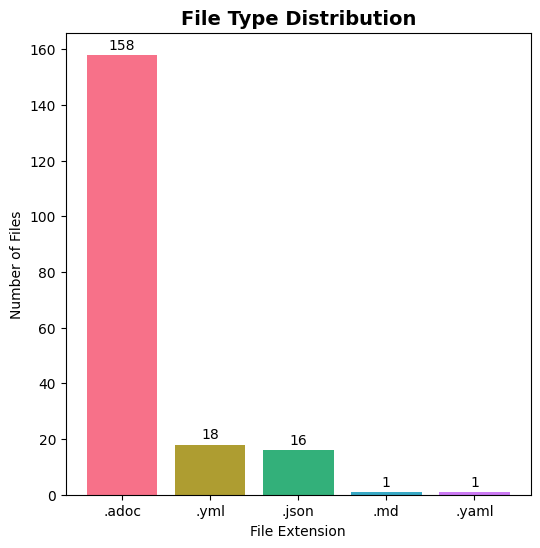

In [5]:
plt.figure(figsize=(6, 6))

ext_counts = df['extension'].value_counts()
bars = plt.bar(ext_counts.index, ext_counts.values, color=sns.color_palette("husl", len(ext_counts)))

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1, 
             f'{int(height)}', ha='center', va='bottom')

plt.title('File Type Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Number of Files')
plt.xlabel('File Extension')

plt.show()

### File Sizes


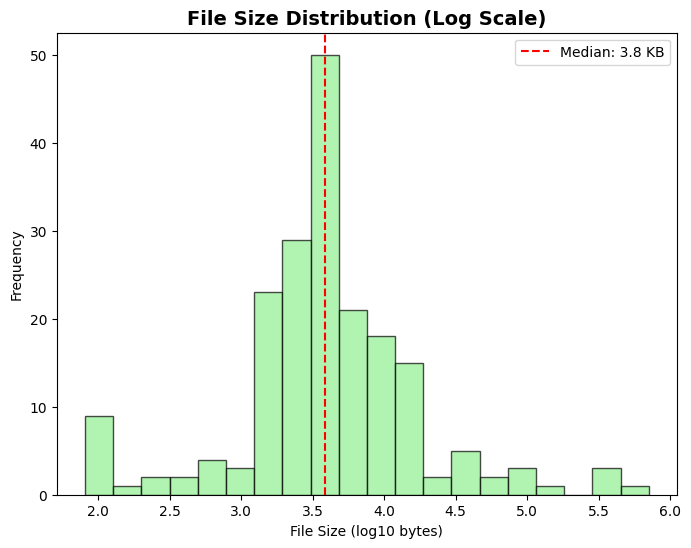

In [6]:
plt.figure(figsize=(8, 6))
plt.hist(np.log10(df['size_bytes']), bins=20, color='lightgreen', alpha=0.7, edgecolor='black')
plt.xlabel('File Size (log10 bytes)')
plt.ylabel('Frequency')
plt.title('File Size Distribution (Log Scale)', fontsize=14, fontweight='bold')
plt.axvline(np.log10(df['size_bytes'].median()), color='red', linestyle='--', 
           label=f'Median: {df["size_bytes"].median()/1024:.1f} KB')
plt.legend()
plt.show()

### Directory Depth
The repo consists of numerous subdirectories (15) and files (194).  The vast majority of the files have a depth of 1, meaning that they are nested in a subdirectory folder and therefore we will need to consider the appropriate methods to crawl/walk through repo hierarchy to absorb file contents.  Additionally, depth (nested files) are important when considering graph modeling.

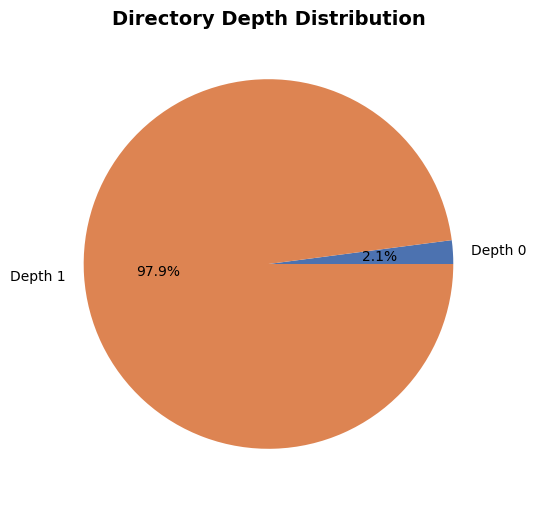

Total files at depth 0: 4
Total files at depth 1: 190


In [7]:
plt.figure(figsize=(8, 6))

depth_counts = df['depth'].value_counts().sort_index()
colors = sns.color_palette("deep", len(depth_counts))
wedges, texts, autotexts = plt.pie(depth_counts.values, labels=[f'Depth {d}' for d in depth_counts.index], 
                                  autopct='%1.1f%%', colors=colors)
plt.title('Directory Depth Distribution', fontsize=14, fontweight='bold')

plt.show()

print(f"Total files at depth 0: {depth_counts[0]}")
print(f"Total files at depth 1: {depth_counts[1]}")

### Directories with the Highest File Count

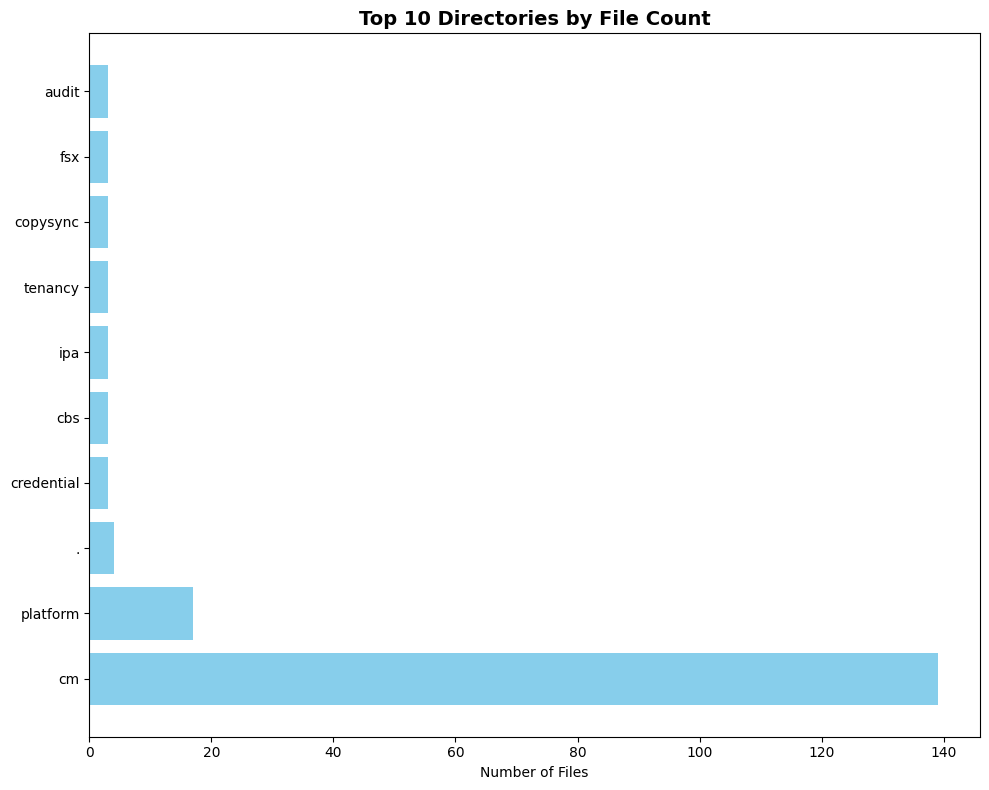

In [8]:
top_dirs = df['directory'].value_counts().head(10)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_dirs)), top_dirs.values, color='skyblue')
plt.yticks(range(len(top_dirs)), [d[:20] + '...' if len(d) > 20 else d for d in top_dirs.index])
plt.xlabel('Number of Files')
plt.title('Top 10 Directories by File Count', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Word Counts by File

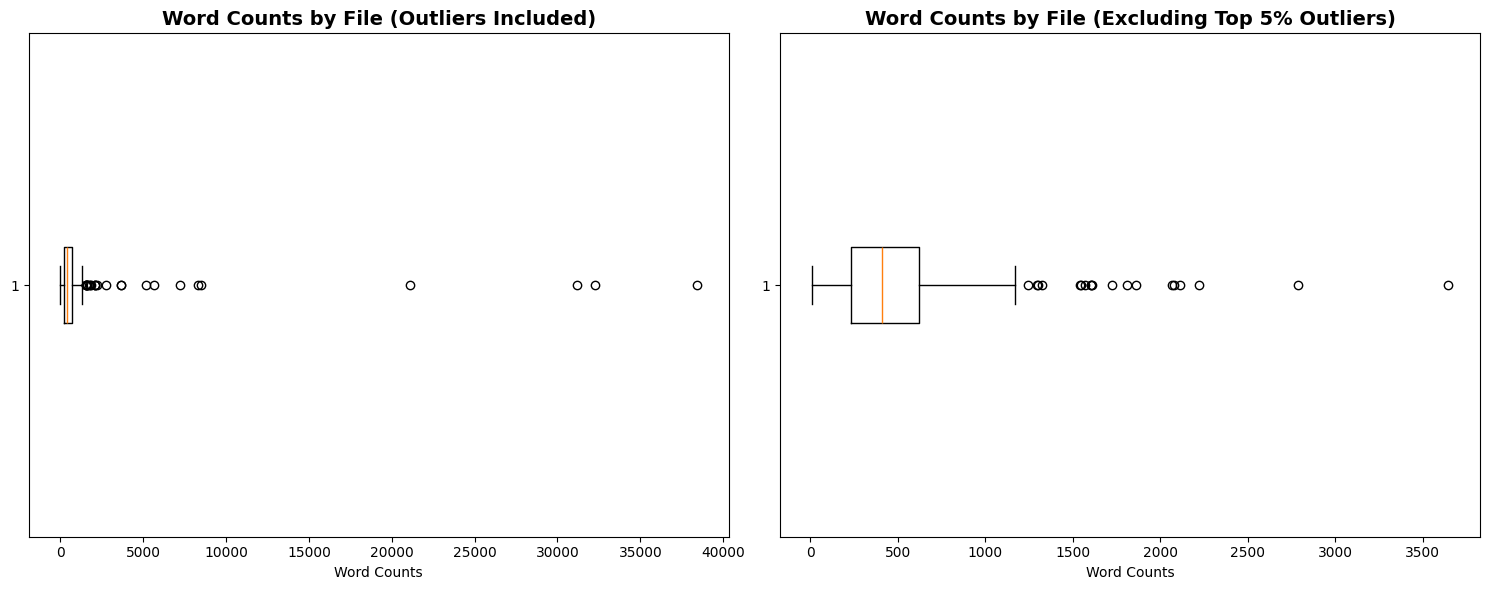

Median word count: 415.0

Number of outliers: 10

Outlier file names:

 ['cbs.json' 'ipa.json' 'tenancy.json' 'copysync.json' 'tenancyv4.yaml'
 'tenancyv4-x-doc.yml' 'dw.json' 'api_ref_resources.adoc'
 'api_ref_definitions.adoc'
 'wf_azure_cloud_md_get_storage_account_types.adoc']


In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.boxplot(df['word_count'], vert=False)
ax1.set_xlabel('Word Counts')
ax1.set_title('Word Counts by File (Outliers Included)', fontsize=14, fontweight='bold')

q95 = df['word_count'].quantile(0.95)
filtered_data = df[df['word_count'] <= q95]
ax2.boxplot(filtered_data['word_count'], vert=False)
ax2.set_xlabel('Word Counts')
ax2.set_title('Word Counts by File (Excluding Top 5% Outliers)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

median_word_count = df['word_count'].median()
print(f"Median word count: {median_word_count}\n")

outliers = df[df['word_count'] > q95]
print(f"Number of outliers: {len(outliers)}\n")
print("Outlier file names:\n\n", outliers['filename'].values)


### Header Counts 

Upon investigation, many of our files have numerous layers of headers (H1, H2, and H3).  H3s dominate the count of headers across our files (specifically adoc files), reflecting that these files have depth in file contents and are likely well organized.  This is beneficial for our task of analyzing the contents and prioritizing the various sections (headers).

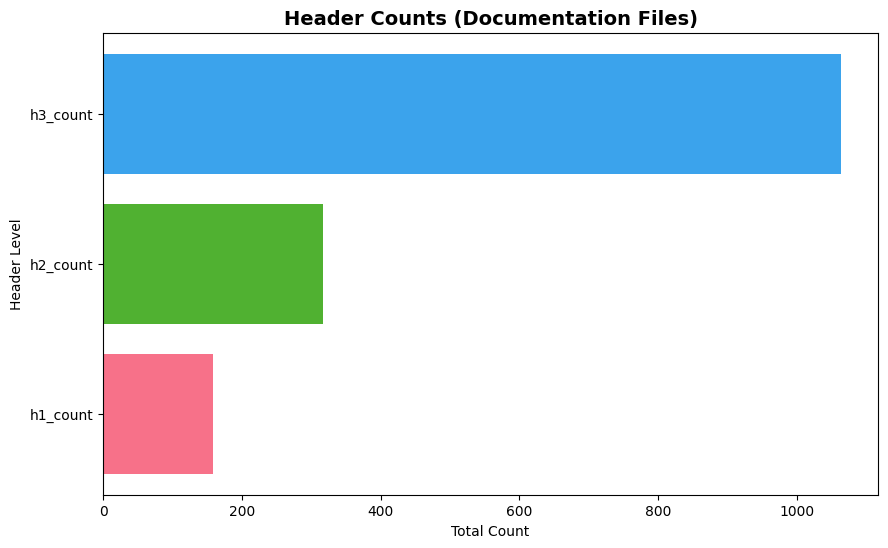

Total H1 headers: 159
Total H2 headers: 317
Total H3 headers: 1064


In [10]:
doc_files = df[df['is_documentation']]
structure_data = doc_files[['h1_count', 'h2_count', 'h3_count']].sum()

plt.figure(figsize=(10, 6))
plt.barh(structure_data.index, structure_data.values, color=sns.color_palette("husl", len(structure_data)))
plt.title('Header Counts (Documentation Files)', fontsize=14, fontweight='bold')
plt.xlabel('Total Count')
plt.ylabel('Header Level')
plt.show()

print(f"Total H1 headers: {structure_data['h1_count']}")
print(f"Total H2 headers: {structure_data['h2_count']}")
print(f"Total H3 headers: {structure_data['h3_count']}")

### Link Analysis

Links can be a good indicator of a file's dependency on external sources, as well as be helpful establishing relationships with various files, concepts, or other resources.  In the case of the BlueXP-Automation API, a large amount of the repo (61% of files) has links.  Upon further analysis, however, the majority of those links are internal links, meaning the dependencies are within the repo.  

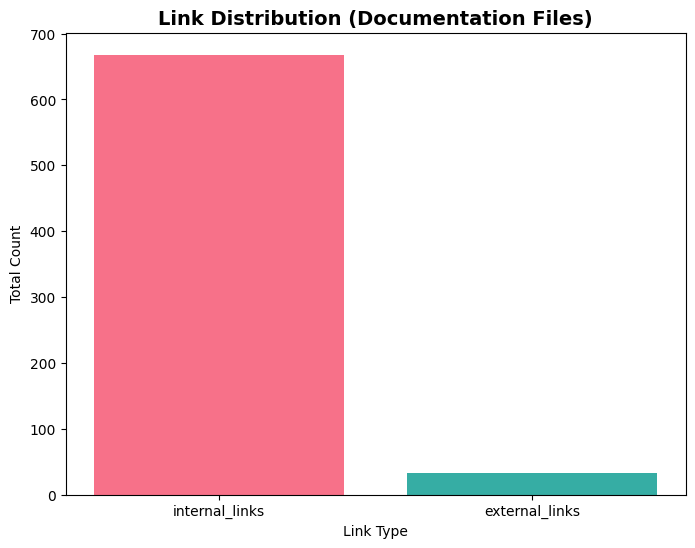

Total internal links: 668
Total external links: 33
Files containing links: 97
Percentage of files with links: 61.0%


In [11]:
link_data = doc_files[['internal_links', 'external_links']].sum()

plt.figure(figsize=(8, 6))
plt.bar(link_data.index, link_data.values, color=sns.color_palette("husl", len(link_data)))
plt.title('Link Distribution (Documentation Files)', fontsize=14, fontweight='bold')
plt.ylabel('Total Count')
plt.xlabel('Link Type')
plt.show()

print(f"Total internal links: {link_data['internal_links']}")
print(f"Total external links: {link_data['external_links']}")
print(f"Files containing links: {(doc_files['total_links'] > 0).sum()}")
print(f'Percentage of files with links: {(doc_files["total_links"] > 0).sum() / len(doc_files) * 100:.1f}%')

### Content Pattern Analysis


In [12]:
def analyze_content_patterns(df):
    
    metrics = []
    
    for idx, row in df.iterrows():
        content = row['content']
        
        lines = content.split('\\n')
        words = content.split()
        
        # Capturing the h1, 2, and 3 headers
        h1_count = len(re.findall(r'^= .+', content, re.MULTILINE))
        h2_count = len(re.findall(r'^== .+', content, re.MULTILINE))
        h3_count = len(re.findall(r'^=== .+', content, re.MULTILINE))
        
        # Capturing the internal and external links in the files
        internal_links = len(re.findall(r'<<[^>]+>>', content))
        external_links = len(re.findall(r'https?://[^\\s]+', content))
        
        # Looking for API endpoints used in the files
        api_endpoints = len(re.findall(r'/(api|v\\d+)/[^\\s]+', content))
        
        metrics.append({
            'filename': row['filename'],
            'line_count': len(lines),
            'word_count': len(words),
            'char_count': len(content),
            'h1_count': h1_count,
            'h2_count': h2_count,
            'h3_count': h3_count,
            'internal_links': internal_links,
            'external_links': external_links,
            'link_density': (internal_links + external_links) / max(len(words), 1) * 100,
            'api_endpoints': api_endpoints,
        })
    
    return pd.DataFrame(metrics)

content_metrics = analyze_content_patterns(df)
content_metrics.head()

,filename,line_count,word_count,char_count,h1_count,h2_count,h3_count,internal_links,external_links,link_density,api_endpoints
0,_index.yml,1,377,3384,0,0,0,0,2,0.530504,0
1,project.yml,1,83,710,0,0,0,0,0,0.000000,0
2,README.md,1,75,550,0,0,0,0,2,2.666667,0
3,legal-notices.adoc,1,46,497,1,0,0,0,1,2.173913,0
4,sidebar.yml,1,1158,12819,0,0,0,0,0,0.000000,0


### Content Complexity Score

In [13]:
def calculate_complexity_score(metrics):
    
    normalized = metrics.copy()
    for col in ['word_count', 'total_headers', 'code_block_count', 'link_density']:
        if col in normalized.columns:
            if normalized[col].max() > normalized[col].min():
                normalized[f'{col}_norm'] = (normalized[col] - normalized[col].min()) / \
                                           (normalized[col].max() - normalized[col].min())
            else:
                normalized[f'{col}_norm'] = 0.0
    
    complexity_components = []
    weights = []
    
    if 'word_count_norm' in normalized.columns:
        complexity_components.append(normalized['word_count_norm'] * 0.3)
        weights.append(0.3)
    
    if 'total_headers_norm' in normalized.columns:
        complexity_components.append(normalized['total_headers_norm'] * 0.2)
        weights.append(0.2)
    
    if 'code_block_count_norm' in normalized.columns:
        complexity_components.append(normalized['code_block_count_norm'] * 0.3)
        weights.append(0.3)
    
    if 'link_density_norm' in normalized.columns:
        complexity_components.append(normalized['link_density_norm'] * 0.2)
        weights.append(0.2)
    
    if complexity_components:
        normalized['complexity_score'] = sum(complexity_components) / sum(weights)
    else:
        normalized['complexity_score'] = 0.0
    
    return normalized[['filename', 'complexity_score']].sort_values('complexity_score', ascending=False)

complexity_scores = calculate_complexity_score(content_metrics)
print("Top 10 Most Complex Documents:")
print(complexity_scores.head(10))

Top 10 Most Complex Documents:
                                      filename  complexity_score
37                               copysync.json          0.600933
49                              tenancyv4.yaml          0.506322
70                      api_ref_resources.adoc          0.487548
46                                  blogs.adoc          0.401625
154                   api_ref_definitions.adoc          0.381441
84   wf_common_identity_get_supported_srv.adoc          0.350991
10                                    cbs.json          0.331770
16                                tenancy.json          0.135760
44                   additional_resources.adoc          0.121962
2                                    README.md          0.120514


### Naming Convention Analysis


In [14]:
def extract_naming_patterns(df):    
    patterns = {
        'prefixes': Counter(),
        'suffixes': Counter(),
        'words': Counter(),
        'separators': Counter(),
        'lengths': [],
        'extensions': Counter()
    }
    
    for filename in df['filename']:
        # Get name without extension
        name_without_ext = filename.rsplit('.', 1)[0]
        
        # Extract prefix (before first underscore)
        if '_' in name_without_ext:
            prefix = name_without_ext.split('_')[0]
            patterns['prefixes'][prefix] += 1
        
        # Extract suffix (after last underscore)
        if '_' in name_without_ext:
            suffix = name_without_ext.split('_')[-1]
            patterns['suffixes'][suffix] += 1
        
        # Extract individual words
        words = re.findall(r'[a-zA-Z]+', name_without_ext)
        for word in words:
            patterns['words'][word.lower()] += 1
        
        # Count separators
        separators = re.findall(r'[^a-zA-Z0-9]', name_without_ext)
        for sep in separators:
            patterns['separators'][sep] += 1
        
        # Record length
        patterns['lengths'].append(len(name_without_ext))
        
        # Record extension
        if '.' in filename:
            ext = filename.split('.')[-1]
            patterns['extensions'][ext] += 1
    
    return patterns

naming_patterns = extract_naming_patterns(df)

print("Naming Pattern Analysis:")
print(f"Total files analyzed: {len(df)}")
print(f"Unique prefixes found: {len(naming_patterns['prefixes'])}")
print(f"Unique words found: {len(naming_patterns['words'])}")
print(f"Average filename length: {np.mean(naming_patterns['lengths']):.1f} characters")
print(f"Most common separator: {naming_patterns['separators'].most_common(1)[0] if naming_patterns['separators'] else 'None'}")

print("\nTop 10 prefixes:")
for prefix, count in naming_patterns['prefixes'].most_common(10):
    print(f"  {prefix}: {count}")

print("\nTop 10 words:")
for word, count in naming_patterns['words'].most_common(10):
    print(f"  {word}: {count}")

Naming Pattern Analysis:
Total files analyzed: 194
Unique prefixes found: 17
Unique words found: 142
Average filename length: 22.4 characters
Most common separator: ('_', 637)

Top 10 prefixes:
  wf: 129
  api: 4
  create: 2
  get: 2
  additional: 2
  : 1
  aa: 1
  http: 1
  workflows: 1
  user: 1

Top 10 words:
  wf: 129
  ontap: 65
  get: 64
  cloud: 48
  create: 39
  gcp: 37
  md: 34
  aws: 29
  azure: 27
  common: 22


### Visualizing Naming Patterns

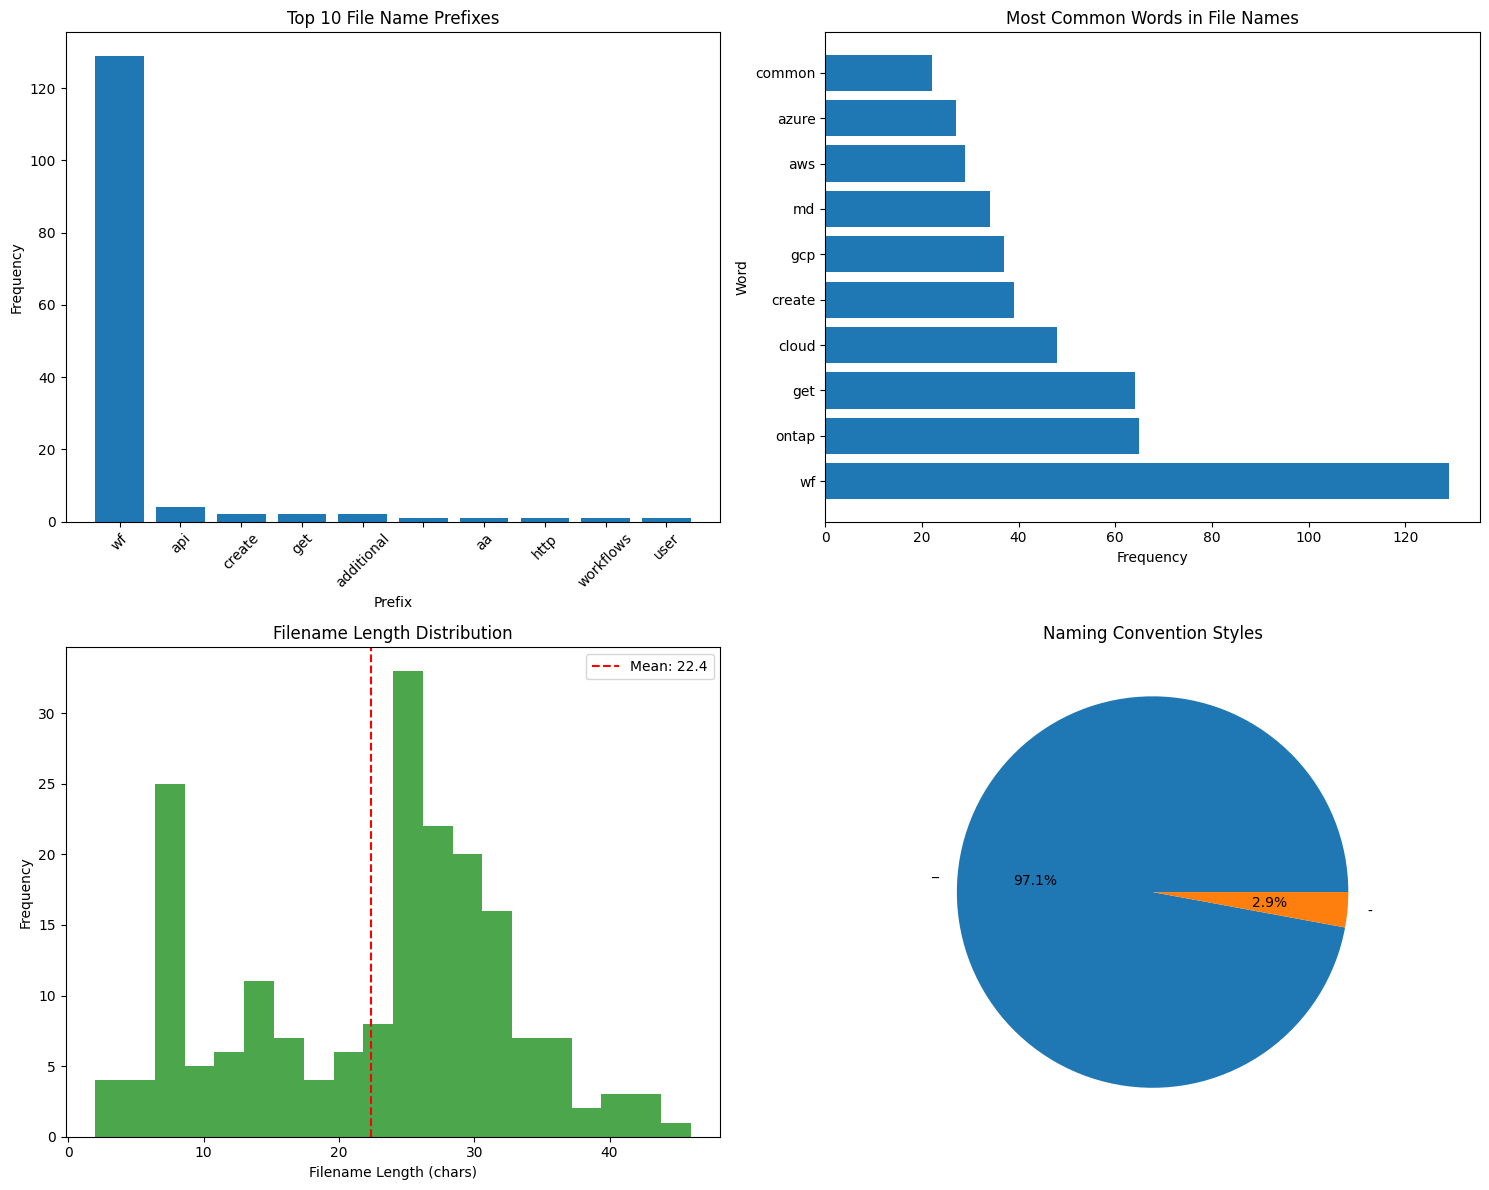

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

top_prefixes = dict(sorted(naming_patterns['prefixes'].items(), key=lambda x: x[1], reverse=True)[:10])
axes[0, 0].bar(top_prefixes.keys(), top_prefixes.values())
axes[0, 0].set_xlabel('Prefix')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Top 10 File Name Prefixes')
axes[0, 0].tick_params(axis='x', rotation=45)

top_words = dict(sorted(naming_patterns['words'].items(), key=lambda x: x[1], reverse=True)[:10])
axes[0, 1].barh(list(top_words.keys()), list(top_words.values()))
axes[0, 1].set_xlabel('Frequency')
axes[0, 1].set_ylabel('Word')
axes[0, 1].set_title('Most Common Words in File Names')

axes[1, 0].hist(naming_patterns['lengths'], bins=20, alpha=0.7, color='green')
axes[1, 0].axvline(np.mean(naming_patterns['lengths']), color='red', linestyle='--',
                    label=f'Mean: {np.mean(naming_patterns["lengths"]):.1f}')
axes[1, 0].set_xlabel('Filename Length (chars)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Filename Length Distribution')
axes[1, 0].legend()

separators = naming_patterns['separators']
axes[1, 1].pie(separators.values(), labels=separators.keys(), autopct='%1.1f%%')
axes[1, 1].set_title('Naming Convention Styles')

plt.tight_layout()
plt.show()

### Pattern-Based File Clustering


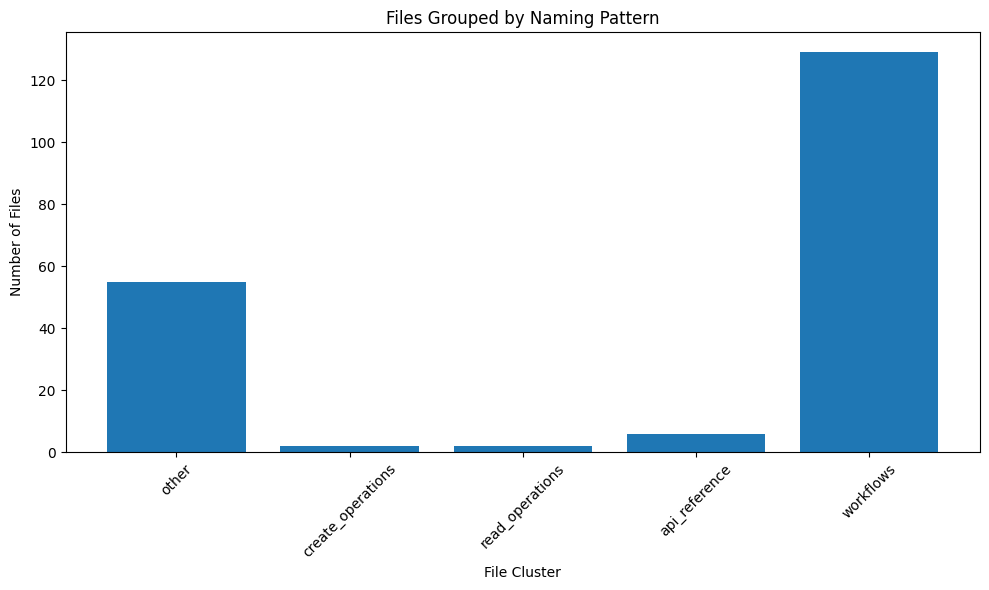

File Clustering Summary:
             cluster  count                                           examples
0              other     55                 _index.yml, project.yml, README.md
1  create_operations      2  create_user_token.adoc, create_service_token.adoc
2    read_operations      2             get_identifiers.adoc, get_nss_key.adoc
3      api_reference      6  api_explorer.adoc, use_rest_apis.adoc, api_ref...
4          workflows    129  wf_gcp_ontap_create_cifs.adoc, wf_azure_ontap_...


In [16]:
def cluster_files_by_pattern(df):
    
    clusters = defaultdict(list)
    
    for idx, row in df.iterrows():
        filename = row['filename']
        name_without_ext = filename.rsplit('.', 1)[0]
        
        if name_without_ext.startswith('wf_'):
            clusters['workflows'].append(filename)
        elif name_without_ext.startswith('get_'):
            clusters['read_operations'].append(filename)
        elif name_without_ext.startswith('create_'):
            clusters['create_operations'].append(filename)
        elif name_without_ext.startswith('update_'):
            clusters['update_operations'].append(filename)
        elif name_without_ext.startswith('delete_'):
            clusters['delete_operations'].append(filename)
        elif 'api' in name_without_ext.lower():
            clusters['api_reference'].append(filename)
        elif 'guide' in name_without_ext.lower() or 'tutorial' in name_without_ext.lower():
            clusters['guides'].append(filename)
        else:
            clusters['other'].append(filename)
    
    cluster_summary = pd.DataFrame([
        {'cluster': k, 'count': len(v), 'examples': ', '.join(v[:3])}
        for k, v in clusters.items()
    ])
    
    return cluster_summary, clusters

cluster_summary, file_clusters = cluster_files_by_pattern(df)

plt.figure(figsize=(10, 6))
plt.bar(cluster_summary['cluster'], cluster_summary['count'])
plt.xlabel('File Cluster')
plt.ylabel('Number of Files')
plt.title('Files Grouped by Naming Pattern')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("File Clustering Summary:")
print(cluster_summary)